In [1]:
import torch
import math
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# **Task**

We train a baseline language model on the Tiny Shakespeare corpus. In particular, we will use character-level tokenization, and predict the next character given the previous $k$ characters (conditional probability over characteers). To achieve this we will train the model to maximize the log-likelihood of the data. 

$$
\max_{\theta} \sum_{i=1}^{N} \hat{p}(\mathbf{x}_i) = \max_{\theta} \sum_{i=1}^{N} \prod_{j=1}^{k} \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta) = \max_{\theta} \sum_{i=1}^{N} \sum_{j=1}^{k} \log \hat{p}(x_j | x_{j-1},..., x_{j-k}; \theta)
$$

where $\mathbf{x}_i$ is the $i$-th sequence in the dataset created from the corpus, $N$ is the number of sequences in the dataset and $\theta$ are the parameters of the model. 

### Multiple context lengths $k$

For large language models (LLMs) such as GPT-2, we in fact train over various context lengths $k$, e.g. we may set a maximum context length of $K$ and train the model on all sequences of length $K$ or less. The above formulation is therefore slightly simplified, but the idea is the same. This modification will also allow our model to learn how to generate text based on only a single character which is useful for generating text from scratch (beginning only with a "space" character).

In the context of creating a dataset, we can think of passing the model a sequence of length $K$ but instead of only predicting the next character based on the entire sequence we will predict the next character for each subsequence of length $k \leq K$. Therefore,  our target will consist of the next character for each subsequence of length $k$:

$$
[x_{1}, x_{2}, ..., x_{K}] \mapsto [x_{2}, x_{3}, ..., x_{K+1}] 
$$ 

In particular, the following subsequence predictions are made:

$$
x_{1} \mapsto x_{2} \\
x_{1}, x_{2} \mapsto x_{3} \\ 
x_{1}, x_{2}, x_{3} \mapsto x_{4} \\
... \\
x_{1}, x_{2}, ..., x_{K} \mapsto x_{K+1}
$$

When using a transformer (decoder) architecture, we can use the same input sequence for all subsequence predictions, but mask out the positions that are not relevant for the prediction.


# **Dataset**

In [2]:
# load data
corpus = open('tiny_shakespeare.txt', 'r').read()
# print(corpus[:100], '...', sep="")

# map each character to an integer and vice versa
chars = sorted(set(corpus))
idx2char = dict(enumerate(chars))
char2idx = {v: k for (k, v) in idx2char.items()}
print(f'\nNo. characteres: {len(corpus)}. Unique set: {chars}')


No. characteres: 1115393. Unique set: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


We use a `get_batch(split)` method as opposed to a sliding window approach to precompile all possible batches. This is due to the heavy overlap between sequences and the amount of memory it would require ($K$ times more). Instead, we will use a random sampling approach to generate batches on the fly.

In [3]:
# Form dataset from corpus
block_size = 20 # context size for next character prediction
batch_size = 32 # batch size for training

# encode corpus (char to int)
enc_corpus = [char2idx[i] for i in corpus[:10000]]

# split into train and validation sets
split_idx = int(len(enc_corpus)*0.9)
enc_train_corpus = enc_corpus[:split_idx]
enc_val_corpus = enc_corpus[split_idx:]

batch_idxs = {'train': [], 'val': []}
def get_batch(split):
    enc_corpus = enc_train_corpus if split == 'train' else enc_val_corpus
    idxs = torch.randint(len(enc_corpus) - block_size, (batch_size,))
    batch_idxs[split] += idxs.tolist()
    xb = torch.stack([torch.tensor(enc_corpus[i:i+block_size]) for i in idxs]) # stack along batch dimension (0)
    yb = torch.stack([torch.tensor(enc_corpus[i+1:i+1+block_size]) for i in idxs])
    return xb, yb

# X, Y = get_batch('train')
# print(f"X.shape: {X.shape} | X.dtype: {X.dtype}")
# print(f"Y.shape: {Y.shape} | Y.dtype: {Y.dtype}")
# for i in range(3):
#     print(f"{X[i]} ---> {Y[i]}")

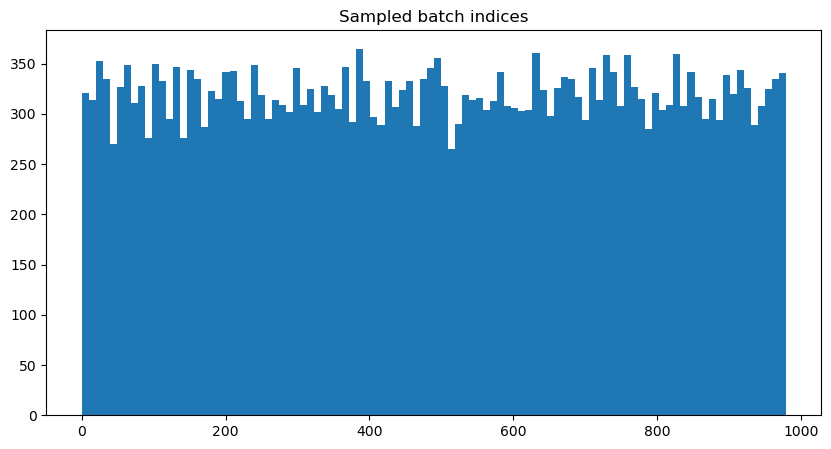

In [9]:
# visualize sampled batch indices
plt.figure(figsize=(10, 5))
plt.title('Sampled batch indices')
plt.hist(batch_idxs['train'], bins=100);

# **GPT model**

In this notebook we present a solution using the transformer architecture. As we are only interested in generating text without any context or prompt, we will only use the decoder part of the transformer. We begin by implementing the decoder stack without any modularity in order simplify the code and provide a clear overview of the model. We will then refactor the code to make it more modular and reusable.

When devising such a model, it is important to increase complexity gradually in order to ensure that the model is able to learn and benefitting from the added complexity. Consequently, one would generally begin without any attention layers and a reduced context length. Then one may increase the context length and use a simplified communication scheme between the tokens (e.g. mean pooling). Finally, one may add attention layers and increase the number of layers. In the below code we skip this process and jump straight to the final model for brevity.

In [ ]:
batch_s = 3     # batch size
seq_l = 5       # sequence length
vocab_s = 6     # vocab size
emb_d = 8       # embedding dimension
h = 2           # number of heads

# basic outline of transformer: 
x_batch = torch.randint(0, vocab_s, (batch_s, seq_l)) # (batch_size, seq_len)

# embedding layer
W_emb = torch.randn(vocab_s, emb_d) # (vocab_size, embedding_dim)
x_emb = W_emb[x_batch] # (batch_size, seq_len, embedding_dim)
# batch_size, seq_len and embedding_dim are often referred to as B, T and C in the literature,
# which stands for batch dimension, temporal dimension and channel dimension, respectively.

# positional encoding
W_pos = torch.randn(seq_l, emb_d) # (seq_len, embedding_dim)
pos_idxs = torch.arange(seq_l) # (seq_len,)
x_pos = W_pos[pos_idxs] # (seq_len, embedding_dim)
x_emb = x_emb + x_pos # (batch_size, seq_len, embedding_dim)

# masked multi-head self-attention 
W_kqv = torch.randn(emb_d, 3*emb_d) # (embedding_dim, 3*embedding_dim)
k, q, v = (x_emb @ W_kqv).split(emb_d, dim=-1) # (batch_size, seq_len, embedding_dim) (3x)
# We split the embedding dimension into h equal parts (one for each attention head).
# Subsequently, we transpose the 1st and 2nd dimension to have batch_s * h batches of 
# seq_l x (emb_d // 2) matrices over which attention is performed.
# When devising such efficient implementations, it is important to test the correctness on small examples.
k = k.view(batch_s, seq_l, h, emb_d // h).transpose(1, 2)
q = q.view(batch_s, seq_l, h, emb_d // h).transpose(1, 2)
v = v.view(batch_s, seq_l, h, emb_d // h).transpose(1, 2)

# We now have a set of `seq_l` queries, keys and values. Each query (projected to from a token/character, embedding) is used to 
# generate a new embedding for said token/character based on its (≤seq_l) predecessors. To ensure that it only consists of 
# its predecessors, we mask out the affinities/weights to all tokens that come after it. This is done prior to applying softmax, 
# by setting those weights to `-inf`. After softmax, these normalized weights become `exp(-inf)/sum(...)` which is 0. This masking 
# process to ensure that the weights are only based on the tokens that come before the current token is called causal masking and 
# is what differentiates a decoder transformer from an encoder transformer. 
tril_mask = torch.ones((seq_l, seq_l)).tril()
wei = q @ k.transpose(-2, -1) / ((emb_d // 2) ** 1/2) # dot product amplifies variance ~> scale back to unit variance 
wei = wei.masked_fill(tril_mask == 0, -torch.inf)
wei = F.softmax(q @ k.transpose(-2, -1), -1) # (batch_size, h, seq_len, seq_len)
x_emb_att = wei @ v # (batch_size, h, seq_len, embedding_dim // h)
x_emb_att = x_emb_att.transpose(1, 2).contiguous().view(batch_s, seq_l, emb_d) # (batch_size, seq_len, embedding_dim)
W_o = torch.randn(emb_d, emb_d) # (embedding_dim, embedding_dim)
x_emb_att = x_emb_att @ W_o # (batch_size, seq_len, embedding_dim)

# add & norm
x_emb = x_emb + x_emb_att
x_emb = F.layer_norm(x_emb, (emb_d,)) # (batch_size, seq_len, embedding_dim)

# cross-attention module
# As we do not require any cross-attention over a prompt or context, we skip this step.

# feed-forward module
d_ff = 4 * emb_d
W_ff1 = torch.randn((emb_d, d_ff))
W_ff2 = torch.randn((d_ff, emb_d))
x_ff = F.relu(x_emb @ W_ff1) @ W_ff2 # (batch_size, seq_len, embedding_dim)

# add & norm
x_emb = x_emb + x_ff
x_emb = F.layer_norm(x_emb, (emb_d,)) # (batch_size, seq_len, embedding_dim)
# In contrast to batch normalization, layer normalization normalizes over the embedding or channel dimension.
# This means that there is also no distinction between training and evaluation time, as the normalization
# is not based on the batch statistics.

# output layer
W_out = torch.randn((emb_d, vocab_s)) 
x_out = x_emb @ W_out # (batch_size, seq_len, vocab_size)

# softmax
logits = F.softmax(x_emb, dim=-1) # (batch_size, seq_len, vocab_size)

## Modules of the GPT model

In [4]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.W_emb = nn.Embedding(vocab_size, emb_dim)
        self.W_pos = nn.Parameter(torch.randn(emb_dim))
    
    def forward(self, x):
        x_emb = self.W_emb(x) + self.W_pos
        return x_emb
    
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.W_kqv = nn.Linear(emb_dim, 3*emb_dim)
        self.W_out = nn.Linear(emb_dim, emb_dim)
        
    def forward(self, x):
       B, T, C = x.shape
       k, q, v = self.W_kqv(x).split(C, dim=-1) # (batch_size, seq_len, embedding_dim) (3x)
       k = k.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2) 
       q = q.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
       v = v.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

       wei = q @ k.transpose(-2, -1) / ((C // self.num_heads) ** 1/2)
       tril_mask = torch.ones((T, T)).tril()
       wei = wei.masked_fill(tril_mask == 0, -torch.inf)
       wei = F.softmax(wei, -1) 
       x_att = (wei @ v).transpose(1, 2).contiguous().view(B, T, C)
       return self.W_out(x_att)
    
class FeedForward(nn.Module):
    def __init__(self, emb_dim, d_ff):
        super().__init__()
        self.W_ff1 = nn.Linear(emb_dim, d_ff)
        self.W_ff2 = nn.Linear(d_ff, emb_dim)
        
    def forward(self, x):
        return self.W_ff2(F.relu(self.W_ff1(x)))
    
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, d_ff):
        super().__init__()
        self.att = MultiHeadAttention(emb_dim, num_heads)
        self.ff = FeedForward(emb_dim, d_ff)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        
    def forward(self, x):
        x_att = self.att(x)
        x_att = self.norm1(x + x_att)
        x_ff = self.ff(x_att)
        x_ff = self.norm2(x_att + x_ff)
        return x_ff
       
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_heads, d_ff, num_layers):
        super().__init__()
        self.emb = Embedding(vocab_size, emb_dim)
        self.blocks = nn.ModuleList([TransformerBlock(emb_dim, num_heads, d_ff) for _ in range(num_layers)])
        self.W_out = nn.Linear(emb_dim, vocab_size)
        
    def forward(self, x):
        x_emb = self.emb(x)
        for block in self.blocks:
            x_emb = block(x_emb)
        x_emb = self.W_out(x_emb)
        return x_emb # careful not to apply softmax here as nn.CrossEntropy already does that for us!
    
    def generate(self, enc_text, max_new_tokens):
        # keep generated text in tensor instead of a list and converting to tensor
        # in each loop. That is not efficient + alot of GPU I/O if using CUDA.
        for _ in range(max_new_tokens):
            probs = F.softmax(self(enc_text[:, -block_size:]), dim=-1) # (B=1, ≤block_size, vocab_size) 
            idx_next = torch.multinomial(probs[0, -1, :], num_samples=1) 
            enc_text = torch.cat((enc_text, idx_next.view(1, 1)), dim=1) # (B=1, ≤block_size)
            
        return enc_text

## Training Loop

In [5]:
batch_size = 32
seq_len = 20
vocab_size = len(chars)
emb_dim = 512
num_heads = 8
d_ff = 2048
num_layers = 1
lr = 1e-3
max_iters = 1000
eval_interval = max_iters // 50
eval_iters = 20

# instantiate model
model = TransformerLM(vocab_size, emb_dim, num_heads, d_ff, num_layers)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# model evaluation loop
# provides a more accurate estimate than the batch-wise loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        total_loss = 0
        for _ in range(eval_iters):
            xb, yb = get_batch(split)
            logits = model(xb).view(-1, vocab_size)
            total_loss += loss_fn(logits, yb.view(-1)).item()
        out[split] = total_loss / eval_iters
    model.train()
    return out

In [6]:
# training loop
for i in range(max_iters):
    # every so often evaluate loss on train and validation sets
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f'step {i}: train_loss={losses["train"]:.5f}, val_loss={losses["val"]:.5f}')

    # sample batch of data
    xb, yb = get_batch('train')

    # forward pass & update
    logits = model(xb).view(-1, vocab_size)
    loss = loss_fn(logits, yb.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

step 0: train_loss=4.20326, val_loss=4.25209
step 20: train_loss=2.53360, val_loss=2.68676
step 40: train_loss=2.35649, val_loss=2.53053
step 60: train_loss=2.27015, val_loss=2.45666
step 80: train_loss=2.23919, val_loss=2.49074
step 100: train_loss=2.18718, val_loss=2.40195
step 120: train_loss=2.13101, val_loss=2.45634
step 140: train_loss=2.10160, val_loss=2.41015
step 160: train_loss=2.06711, val_loss=2.44320
step 180: train_loss=2.04489, val_loss=2.42858
step 200: train_loss=2.05071, val_loss=2.44038
step 220: train_loss=1.97020, val_loss=2.50556
step 240: train_loss=1.97816, val_loss=2.50036
step 260: train_loss=1.90726, val_loss=2.50221
step 280: train_loss=1.88336, val_loss=2.51762
step 300: train_loss=1.87693, val_loss=2.48133
step 320: train_loss=1.82275, val_loss=2.53423
step 340: train_loss=1.80910, val_loss=2.54666
step 360: train_loss=1.77186, val_loss=2.53385
step 380: train_loss=1.77898, val_loss=2.59397
step 400: train_loss=1.78773, val_loss=2.56731
step 420: train_los

## Generate Text

In [7]:
num_gen_tokens = 1000
start = torch.zeros((1, 1), dtype=torch.long)
enc_text = model.generate(start, max_new_tokens=num_gen_tokens)
print(''.join([idx2char[i] for i in enc_text.flatten().tolist()]))



They grouch rm
ey rand rats thayoucan
Of mou he ongestt did t
Ofoto wie f thosole speas cireare thofon thever cer ather athil conof athe cire thir ir ath, ato an m d the ar vis fisthevirth?





Sens Recesoffarare arere t t tecus on o h mourpemourarts;rth hakanerr at h, e, he we heathe he t silll rel stonatr tot w for ffom sebrororit:e and, of awe thone thecof, sey ar thel d meircagaino's at; letete labe ane e! Whelly g yeathe:
They ikim gou s r h ou
Courave muravit sce W. do asthe the? kit cone Wha me whath y inse, belere magour elly. Winainsth acond t woale f knomithat s s windse-he thon ho ane thof Rome good vene?


Fireco Cititizen:
You mor ar ant aly agndinfoupd rthed at cienge aneve a fo thire at t s foreve theme ogod astnd od tnd fo othrot ciemo' Cithe rithe Ci titizen:
One wome ay st say ie itenou, in ache ar at at ansiresir: the the anthe al latey swerererered.

MENIUS:
Sill What's myout t kite,-----ou nd, se
Fo loot the, mo mast at
The gofodstst ormo' fost:
The ageir alifir